## Predicting Cognitive Decline from fMRI Images




## Import dataset



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import nibabel as nib

In [ ]:
#Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Shareable dataset link 
link = 'https://drive.google.com/open?id=1kRmKO46kRQUOJMbF-aga2s-J1bxGCOhu'

genlink, id = link.split('=')
print (id) 

1kRmKO46kRQUOJMbF-aga2s-J1bxGCOhu


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('IXI.csv')  

#Open the demographics table using the pandas package (pd)
df = pd.read_csv('IXI.csv')
df.head(5)

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaN,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.80
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.78
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.71
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.24


In [ ]:
#Remove not a number values 
trim1 = df.dropna()

#Rename or drop columns
trim2 = trim1.drop(columns=['DATE_AVAILABLE', 'STUDY_DATE', 'DOB'])
trim2.rename(columns={'SEX_ID (1=m, 2=f)':'SEX', 'QUALIFICATION_ID': 'EDUCATION'}, inplace=True)

#Final working dataset
f = trim2
f.head(5)

,IXI_ID,SEX,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,EDUCATION,AGE
1,2,2,164,58,1,4,1,5,35.80
2,12,1,175,70,1,2,1,5,38.78
3,13,1,182,70,1,2,1,5,46.71
4,14,2,163,65,1,4,1,5,34.24
5,15,1,181,90,2,1,6,5,24.28


## Exploratory analysis


In [ ]:
print('There are {} patients in the cleaned dataset out of the {} in the original dataset.'.format(len(f), len(df)))
print('There are {} different heights represented and {} different weights.'.format(len(f.HEIGHT.unique()), len(f.WEIGHT.unique())))
print('{f}% of patients in the dataset are female while {m}% are male.'.format(f=np.mean(f.SEX == 1)*100, m=np.mean(f.SEX == 2)*100))


There are 590 patients in the cleaned dataset out of the 619 in the original dataset.
There are 54 different heights represented and 72 different weights.
44.40677966101695% of patients in the dataset are female while 55.59322033898305% are male.


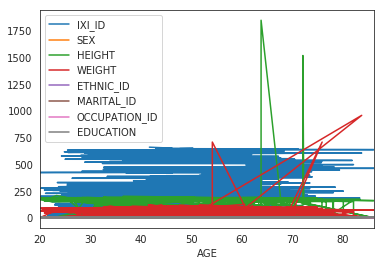

In [ ]:
lines = f.plot.line(x='AGE')

Text(0.5, 1.0, 'Figure 1. Patient distribution by age')

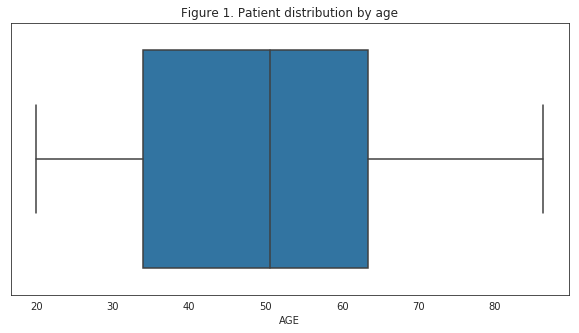

In [ ]:
plt.figure(figsize=(10,5)) 
sns.boxplot(x='AGE', data=f)
plt.title('Figure 1. Patient distribution by age')

## Preprocessing

In [ ]:
#Upload T1 Images
from google.colab import files
t1 = files.upload()

Saving IXI-T1.nii.gz to IXI-T1.nii.gz


In [ ]:
#Upload T2 Images
from google.colab import files
t2 = files.upload()

Saving IXI-T2.nii.gz to IXI-T2.nii.gz


In [ ]:
#Load NIfTI image
image = nib.load('IXI-T1.nii.gz').get_data()
split = nib.load('IXI-T2.nii.gz').get_data()
contrast = image * (split > 0)

In [ ]:
#Axis of brain to analyze: 0 (sagittal), 1 (coronal) or 2 (axial)
sdimension = 0
cdimension = 1
adimension = 2

#Choose plane selection of MRI (I used exactly half of each range)
sslice = 91
cslice = 109
aslice = 91

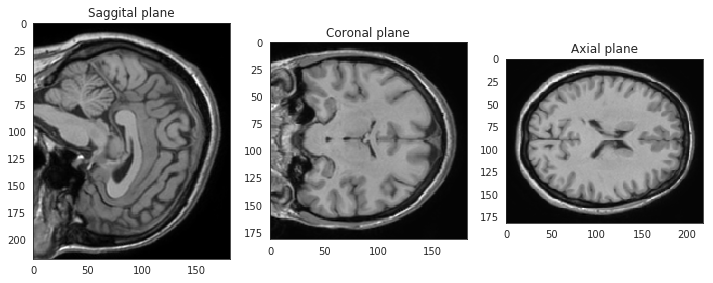

In [ ]:
#plt.suptitle('T1 image planes')

plt.figure(figsize=(12, 7))

plt.subplot(131)
plt.imshow(np.take(image, sslice, sdimension))
plt.title('Saggital plane');

plt.subplot(132)
plt.imshow(np.take(image, cslice, cdimension))
plt.title('Coronal plane');

plt.subplot(133)
plt.imshow(np.take(image, aslice, adimension))
plt.title('Axial plane');

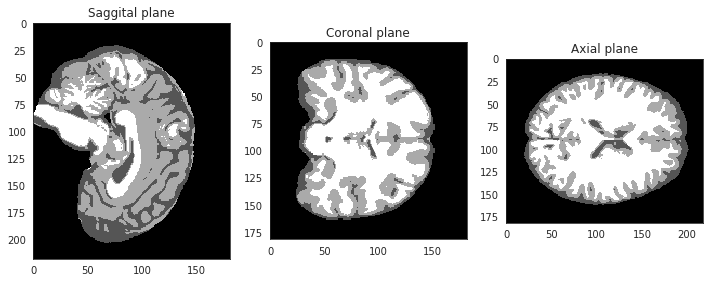

In [ ]:
#plt.suptitle('T2 skull stripped planes')

plt.figure(figsize=(12, 7))

plt.subplot(131)
plt.imshow(np.take(split, sslice, sdimension))
plt.title('Saggital plane');

plt.subplot(132)
plt.imshow(np.take(split, cslice, cdimension))
plt.title('Coronal plane');

plt.subplot(133)
plt.imshow(np.take(split, aslice, adimension))
plt.title('Axial plane');

Text(0.5, 1.0, 'Graph of pixel intensity vs. frequency along axis of brain')

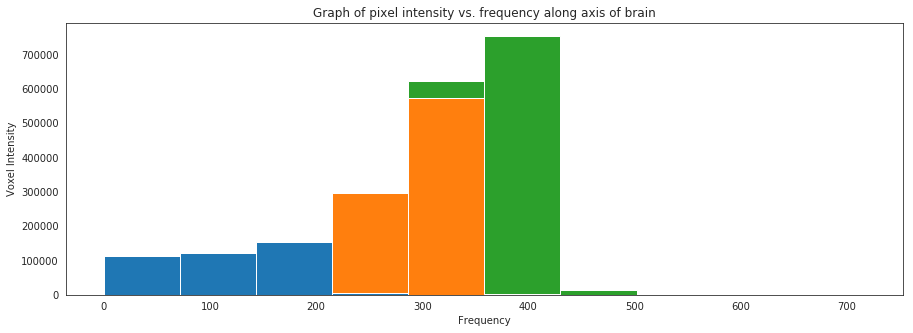

In [ ]:
#Contrast image allows us to superimpose histograms of intensity values
plt.figure(figsize=(15, 5))
plt.hist([contrast[split == tissue] for tissue in [1, 2, 3]], stacked=True);
plt.xlabel('Frequency')
plt.ylabel('Voxel Intensity')
plt.title('Graph of pixel intensity vs. frequency along axis of brain')

## Initial model


In [ ]:
#Upload histograms.npy
from google.colab import files
input = files.upload()

Saving histograms.npy to histograms.npy


In [ ]:
X = np.load('histograms.npy')
Y = f.AGE.values

Text(0, 0.5, 'Average intensity')

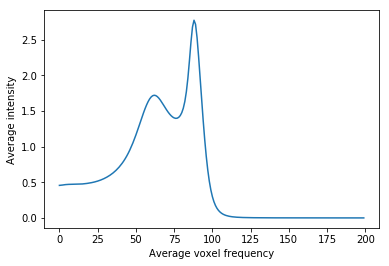

In [ ]:
plt.plot(X.mean(axis=0))
plt.xlabel('Average voxel frequency')
plt.ylabel('Average intensity')

In [ ]:
#Import SciKit Learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [ ]:
def linear_regression(train_set, test_set):
    model = Ridge()
    model.fit(X[train_set], Y[train_set])
    predicted = model.predict(X[test_set])
    actual = Y[test_set]
    error = np.mean(np.abs(predicted - actual))
    plt.xlabel('Predicted age')
    plt.ylabel('True age')
    plt.title('Average error: {} years'.format(error))
    plt.scatter(predicted, actual, s=10)
    plt.grid()
    plt.show()

Linear regression using 118 patients in the test set and 472 in the training set.


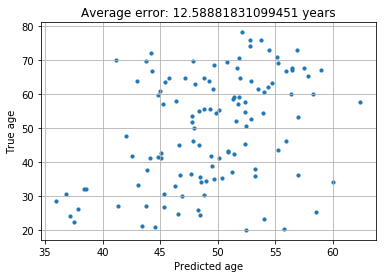

In [ ]:
n = len(f)
train_set, test_set = train_test_split(np.arange(n), test_size=0.2, random_state=0)
print('Linear regression using {} patients in the test set and {} in the training set.'.format(len(test_set), len(train_set)))

linear_regression(train_set, test_set)

## Altered model


In [ ]:
def linear_regression2(train_set, test_set):
    model = RidgeCV()
    model.fit(X[train_set], Y[train_set])
    predicted = model.predict(X[test_set])
    actual = Y[test_set]
    error = np.mean(np.abs(predicted - actual))
    plt.xlabel('Predicted age')
    plt.ylabel('True age')
    plt.title('Average error: {} years'.format(error))
    plt.scatter(predicted, actual, s=10)
    plt.grid()
    plt.show()


Linear regression using 118 patients in the test set and 472 in the training set.


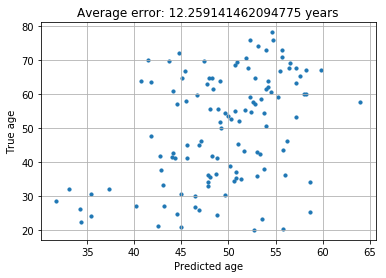

In [ ]:
train_set, test_set = train_test_split(np.arange(n), test_size=0.2, random_state=0)
print('Linear regression using {} patients in the test set and {} in the training set.'.format(len(test_set), len(train_set)))

linear_regression2(train_set, test_set)